In [ ]:
          # Navigation task for food delivary robot.
import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt


class Actions:
    """Contiguous:
        Action is a tuple of length 2, where the first element is the x-axis and the second element is the y-axis.
        UP/DOWN -> action[0]
        LEFT/RIGHT -> action[1]
        Agent will:
        action[0]>0.5 -> try to go UP
        action[0]<=-0.5 -> try to go DOWN
        action[1]>0.5 -> try to go RIGHT
        action[1]<=-0.5 -> try to go LEFT
        
        Discrete: Action can be chosen from 
        ['UP', 'DOWN', 'RIGHT', 'LEFT', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
    """
    
    def __init__(self):
        self.actions={
            'UP': np.array([1.0, 0.0]),
            'DOWN': np.array([-1.0, 0.0]),
            'RIGHT': np.array([0.0, 1.0]),
            'LEFT': np.array([0.0, -1.0]),
            'UPRIGHT': np.array([1.0, 1.0]),
            'UPLEFT': np.array([1.0, -1.0]),
            'DOWNRIGHT': np.array([-1.0, 1.0]),
            'DOWNLEFT': np.array([-1.0, -1.0]),
        }
    
    def UP(self):
        return self.actions['UP'].copy()
    
    def DOWN(self):
        return self.actions['DOWN'].copy()
    
    def RIGHT(self):
        return self.actions['RIGHT'].copy()
    
    def LEFT(self):
        return self.actions['LEFT'].copy()
    
    def UPRIGHT(self):
        return self.actions['UPRIGHT'].copy()
    
    def UPLEFT(self):
        return self.actions['UPLEFT'].copy()
    
    def DOWNRIGHT(self):
        return self.actions['DOWNRIGHT'].copy()
    
    def DOWNLEFT(self):
        return self.actions['DOWNLEFT'].copy()
    

class GridEnv(gym.Env):
    def __init__(self, load_chars_rep_fromd_dir='', init_chars_representation='O O O\nO A O\nO O T', max_steps=100, r_fall_off=-1, r_reach_target=1, r_timeout=0, r_continue=0, render_mode='human', obs_mode='single_rgb_array', render_width=0, render_height=0):
        """
        For reward function:
            Falling off the edge = r_fall_off
            Reached Target = r_reach_target
            Timeout = r_timeout
            Continue one step = r_continue            
        
        For Char Representation:
            A: Agent
            T: Target location
            O: Empty Ground spot (where the agent can step on and stay)
            W: Wall
            H: Hole (where the agent will fall if it steps in)
        Args:
            load_chars_rep_fromd_dir (str, optional): load chars_representation from a txt file. Overwrite init_chars_representation. Defaults to ''.
            init_chars_representation (str, optional): char representation of this grid-world. Defaults to 'O O O\nO A O\nO O T'.
            max_steps (int, optional): max game length. Defaults to 100.
            r_fall_off (int, optional): reward for falling off. Defaults to -1.
            r_reach_target (int, optional): reward for reaching target. Defaults to 1.
            r_timeout (int, optional): reward for ending the game with timeout. Defaults to 0.
            r_continue (int, optional): reward for continuing the game. Defaults to 0.
            render_mode (str, optional): None, 'chars_world' or 'single_rgb_array'. Defaults to 'chars_world'.
            obs_mode (str, optional): 'chars_world' or 'single_rgb_array'. Defaults to 'single_rgb_array'.
            render_width (int, optional): width of the rendered image. If 0, use the original size of char_world. Defaults to 0.
            render_height (int, optional): height of the rendered image. If 0, use the original size of char_world. Defaults to 0.
        """
        self.actions=Actions()
        self.colors = {
            'A': [255, 0, 0], # red
            'T': [0, 255, 0], # green
            'O': [0, 0, 0], # black
            'W': [255, 255, 255], # white
            'H': [0, 0, 255], # blue
        }
        if load_chars_rep_fromd_dir:
            with open(load_chars_rep_fromd_dir, 'r') as f:
                self.init_chars_representation = f.read()
        else:
            self.init_chars_representation = init_chars_representation
        self.max_steps = max_steps
        self.r_fall_off = r_fall_off
        self.r_reach_target = r_reach_target
        self.r_timeout = r_timeout
        self.r_continue = r_continue
        self.chars_world, self.width, self.height = self.chars_to_world(self.init_chars_representation)
        self.action_space = gym.spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)
        self.observation_space = gym.spaces.Space(shape=self.chars_world.shape, dtype=self.chars_world.dtype)
        self.render_mode = render_mode
        self.obs_mode = obs_mode
        self.render_width = render_width
        self.render_height = render_height
        # self.renderer = None
        # if self.render_mode == 'single_rgb_array':
        #     self.renderer = gym.utils.Renderer(self.render_mode, self._render_frame)
        
    
    def reset(self, seed=None, return_info=False, options=None):
        self.step_count = 0
        self.chars_world, self.width, self.height = self.chars_to_world(self.init_chars_representation)
        a_arr_loc = np.where(self.chars_world == 'A')
        self.a_y = a_arr_loc[0][0]
        self.a_x = a_arr_loc[1][0]
        obs = self.chars_world_to_obs(self.chars_world)
        return obs
        
    def step(self, action: np.ndarray):
        assert self.a_x >= 0 and self.a_x < self.width and self.a_y >= 0 and self.a_y < self.height
        if self.step_count >= self.max_steps:
            obs = self.chars_world_to_obs(self.chars_world) # agent is still kept the world where it was last seen.
            reward = self.r_timeout
            terminated = False
            truncated = True
            done = True
            info = {
                'chars_world': self.chars_world,
                'terminated': terminated,
                'truncated': truncated,
                'done': done,
            }
            self.render(mode=self.render_mode)
            return obs, reward, done, info

        result = [0,0,0,0] 
        # the first, second, third and last zeros represents 'fall', 'fail', 'success', 'target'.
        # if result == [0,0,0,0], means the agent stays in the same place without a moving action. 
        # Note that the agent can both move up and right at one step.
        if action[0] > 0.5: # going up
            self.move_to(self.a_y-1, self.a_x, result)
        if action[0] < -0.5: # going down
            self.move_to(self.a_y+1, self.a_x, result)
        if action[1] > 0.5: # going right
            self.move_to(self.a_y, self.a_x+1, result)
        if action[1] < -0.5: # going left
            self.move_to(self.a_y, self.a_x-1, result)
        
        if result[0] == 1: # fall
            obs = self.chars_world_to_obs(self.chars_world) # agent is still kept the world where it was last seen.
            reward = self.r_fall_off
            terminated = True
            truncated = False
            done = True
            info = {
                'chars_world': self.chars_world,
                'terminated': terminated,
                'truncated': truncated,
                'done': done,
                'move_result': result,
            }
            self.render(mode=self.render_mode)
            return obs, reward, done, info
        elif result[3] == 1: # reach target
            obs = self.chars_world_to_obs(self.chars_world) # agent is still kept the world where it was last seen.
            reward = self.r_reach_target
            terminated = True
            truncated = False
            done = True
            info = {
                'chars_world': self.chars_world,
                'terminated': terminated,
                'truncated': truncated,
                'done': done,
                'move_result': result,
            }
            self.render(mode=self.render_mode)
            return obs, reward, done, info
            
        self.step_count += 1
        
        obs = self.chars_world_to_obs(self.chars_world)
        reward = self.r_continue
        terminated = False
        truncated = False
        done = False
        info = {
            'chars_world': self.chars_world,
            'terminated': terminated,
            'truncated': truncated,
            'done': done,
            'move_result': result,
        }
        self.render(mode=self.render_mode)
        return obs, reward, done, info
        
    def move_to(self, y, x, result):
        """
            This is the distance=1 move action.
            move result should be one of:
            'fall'
            'fail'
            'success'
            'target'
            that is represented by the first, second, third and last element of result.
        """
        
        if (not (x >= 0 and x < self.width and y >= 0 and y < self.height)) or self.chars_world[y, x] == 'H':
            result[0] = 1
            return 'fall'
        elif self.chars_world[y, x] == 'O':
            self.chars_world[self.a_y, self.a_x] = 'O'
            self.chars_world[y, x] = 'A'
            self.a_y = y
            self.a_x = x
            result[2] = 1
            return 'success'
        elif self.chars_world[y, x] == 'W':
            result[1] = 1
            return 'fail'
        elif self.chars_world[y, x] == 'T':
            result[3] = 1
            return 'target'
        else:
            raise Exception(f'Unknown char: {self.chars_world[y, x]}, y: {y}, x: {x}, chars_world: {str(self.char_world)}')
        
    def chars_to_world(self, chars_representation):
        chars_world = np.array([line.split(' ') for line in chars_representation.split('\n')], dtype='<U1')
        height, width = chars_world.shape
        return chars_world, width, height
    
    def chars_world_to_rgb_array(self, chars_world):
        rgb_image = np.zeros((*chars_world.shape,3), dtype='uint8')
        for x in range(chars_world.shape[1]):
            for y in range(chars_world.shape[0]):
                if chars_world[y, x] == 'A':
                    rgb_image[y, x, :] = self.colors['A']
                elif chars_world[y, x] == 'T':
                    rgb_image[y, x, :] = self.colors['T']
                elif chars_world[y, x] == 'O':
                    rgb_image[y, x, :] = self.colors['O']
                elif chars_world[y, x] == 'W':
                    rgb_image[y, x, :] = self.colors['W']
                elif chars_world[y, x] == 'H':
                    rgb_image[y, x, :] = self.colors['H']
                else:
                    raise Exception(f'Unknown char: {chars_world[y, x]}, y: {y}, x: {x}, chars_world: {str(chars_world)}')
        return rgb_image
    
    def chars_world_to_obs(self, chars_world):
        if self.obs_mode == 'chars_world':
            return chars_world
        elif self.obs_mode == 'single_rgb_array':
            rgb_img_array = self.chars_world_to_rgb_array(chars_world)
            if self.render_width == 0 and self.render_height == 0:
                return rgb_img_array
            else:
                return cv2.resize(rgb_img_array, (self.render_width, self.render_height), interpolation = cv2.INTER_NEAREST)  
        else:
            raise Exception(f'Unknown obs mode: {self.obs_mode}')
        
    def render(self, mode="human"):
        if mode is None:
            return None
        elif mode == "human":
            plt.imshow(env.chars_world_to_rgb_array(env.chars_world))
            cv2.waitKey(10)
        elif mode == "single_rgb_array":
            return self.chars_world_to_rgb_array(self.chars_world)
        
    def close(self):
        cv2.destroyAllWindows()

[['A' 'O' 'O' 'O']
 ['O' 'W' 'O' 'W']
 ['O' 'O' 'O' 'W']
 ['W' 'O' 'O' 'T']]


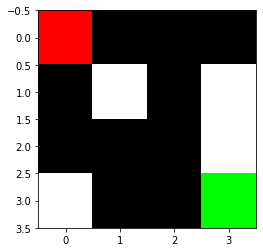

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


env = GridEnv(load_chars_rep_fromd_dir='', init_chars_representation='A O O O\nO W O W\nO O O W\nW O O T')
env.reset()
print(env.chars_world)
plt.imshow(env.chars_world_to_rgb_array(env.chars_world))

0 {'chars_world': array([['O', 'O', 'O', 'O'],
       ['A', 'W', 'O', 'W'],
       ['O', 'O', 'O', 'W'],
       ['W', 'O', 'O', 'T']], dtype='<U1'), 'terminated': False, 'truncated': False, 'done': False, 'move_result': [0, 0, 1, 0]}


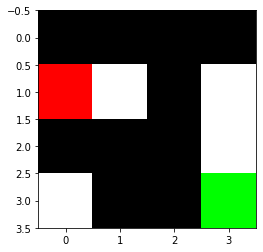

In [ ]:
o=env.step(action = env.actions.DOWN())
print(o[1], o[3])

0 {'chars_world': array([['O', 'O', 'O', 'O'],
       ['O', 'W', 'O', 'W'],
       ['A', 'O', 'O', 'W'],
       ['W', 'O', 'O', 'T']], dtype='<U1'), 'terminated': False, 'truncated': False, 'done': False, 'move_result': [0, 0, 1, 0]}


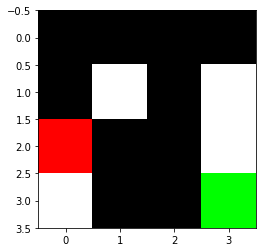

In [ ]:
o=env.step(action = env.actions.DOWN())
print(o[1], o[3])

0 {'chars_world': array([['O', 'O', 'O', 'O'],
       ['O', 'W', 'O', 'W'],
       ['O', 'A', 'O', 'W'],
       ['W', 'O', 'O', 'T']], dtype='<U1'), 'terminated': False, 'truncated': False, 'done': False, 'move_result': [0, 0, 1, 0]}


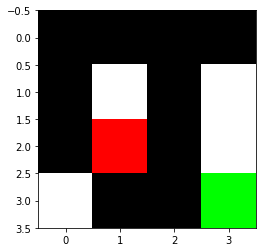

In [ ]:
o=env.step(action = env.actions.RIGHT())
print(o[1], o[3])

0 {'chars_world': array([['O', 'O', 'O', 'O'],
       ['O', 'W', 'O', 'W'],
       ['O', 'O', 'A', 'W'],
       ['W', 'O', 'O', 'T']], dtype='<U1'), 'terminated': False, 'truncated': False, 'done': False, 'move_result': [0, 0, 1, 0]}


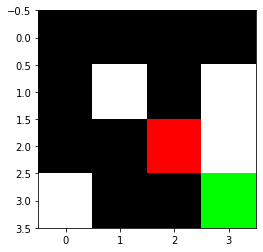

In [ ]:
o=env.step(action = env.actions.RIGHT())
print(o[1], o[3])

0 {'chars_world': array([['O', 'O', 'O', 'O'],
       ['O', 'W', 'O', 'W'],
       ['O', 'O', 'O', 'W'],
       ['W', 'O', 'A', 'T']], dtype='<U1'), 'terminated': False, 'truncated': False, 'done': False, 'move_result': [0, 0, 1, 0]}


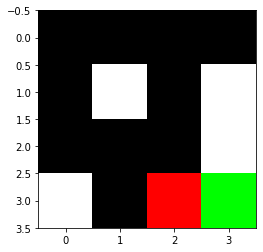

In [ ]:
o=env.step(action = env.actions.DOWN())
print(o[1], o[3])

1 {'chars_world': array([['O', 'O', 'O', 'O'],
       ['O', 'W', 'O', 'W'],
       ['O', 'O', 'O', 'W'],
       ['W', 'O', 'A', 'T']], dtype='<U1'), 'terminated': True, 'truncated': False, 'done': True, 'move_result': [0, 0, 0, 1]}


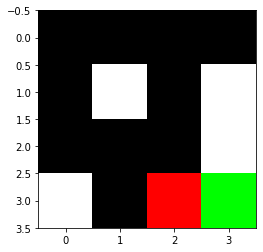

In [ ]:
o=env.step(action = env.actions.RIGHT())
print(o[1], o[3])